In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
block_size = 3
  
def build_dataset(words):
  X, Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb)            , generator=g)
# kaiming init
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3)/((n_emb * block_size)**0.5)#* 0.2
# b1 = torch.rand(n_hidden                       , generator=g) * 0.01 #since this bias does not do anything with batch norm
W2 = torch.randn((n_hidden, vocab_size)        , generator=g) * 0.01
b2 = torch.rand(vocab_size                     , generator=g) * 0

# Batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, W2, b1, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


tensor(-0.0022) tensor(1.0033)
tensor(-0.0012) tensor(0.9948)


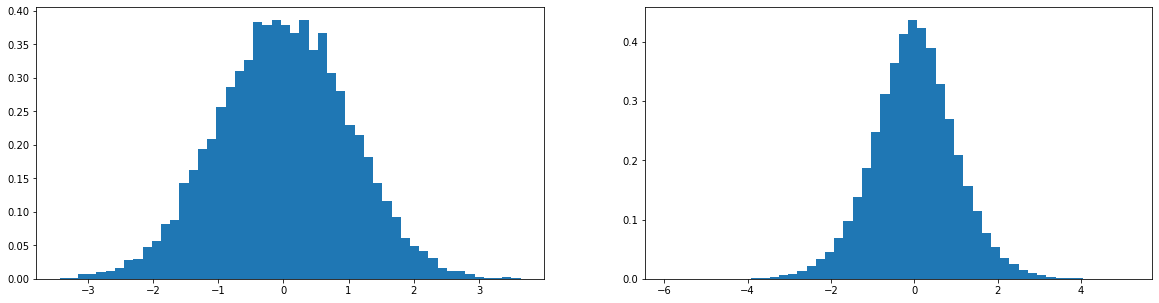

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


In [ ]:
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):
  # construct mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1 #+ b1
  
  # batch normalization
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  # Non-Linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 # lrs[i]
  for p in parameters:
    p.data += -lr * p.grad
    
  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

# print(loss.item())

      0/ 200000: 3.3050
  10000/ 200000: 2.1019
  20000/ 200000: 2.3220
  30000/ 200000: 2.3868
  40000/ 200000: 1.7870
  50000/ 200000: 2.3814
  60000/ 200000: 2.0526
  70000/ 200000: 2.3135
  80000/ 200000: 1.7175
  90000/ 200000: 2.6280
 100000/ 200000: 2.2414
 110000/ 200000: 1.7347
 120000/ 200000: 2.2200
 130000/ 200000: 1.9235
 140000/ 200000: 2.0191
 150000/ 200000: 1.9697
 160000/ 200000: 1.9346
 170000/ 200000: 1.8197
 180000/ 200000: 1.9451
 190000/ 200000: 1.7764


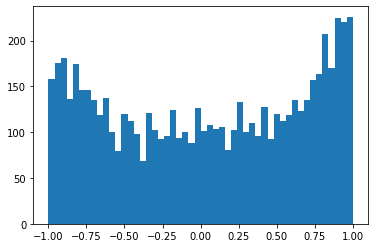

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

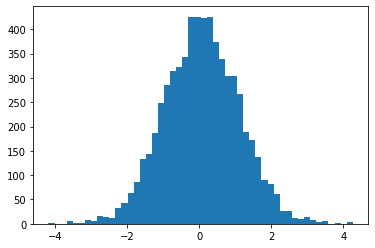

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

<matplotlib.image.AxesImage>

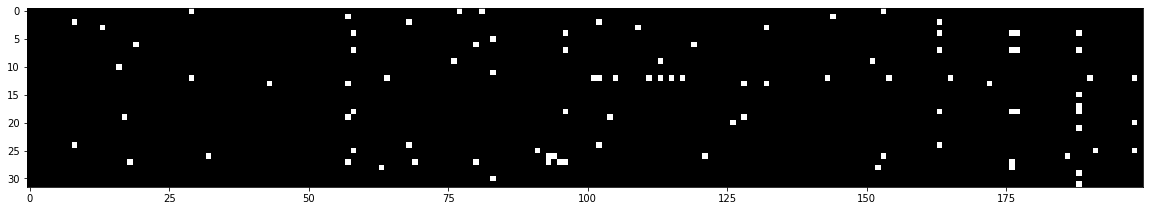

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

[<matplotlib.lines.Line2D>]

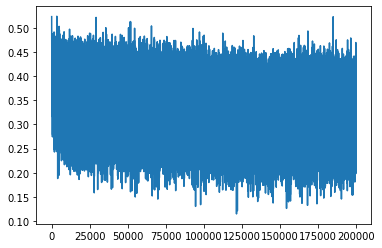

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate bnmean and bnstd

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnstd

tensor([[2.2545, 2.1398, 2.0476, 2.1038, 2.2538, 2.2605, 2.1980, 2.5163, 2.2881,
         2.3039, 2.2750, 2.1152, 2.0418, 2.2582, 2.0147, 2.6525, 2.4520, 1.8471,
         2.3756, 2.5333, 2.2523, 2.3539, 1.9793, 2.1140, 2.3134, 1.8738, 2.1094,
         2.2985, 2.4959, 2.3589, 1.8162, 1.9898, 2.2293, 1.8973, 2.0547, 2.0355,
         2.3698, 2.2216, 2.0111, 1.7562, 2.1222, 2.2688, 2.4619, 1.7629, 2.2810,
         2.1531, 2.3883, 2.6125, 2.1320, 2.4058, 1.9583, 1.8365, 2.2034, 1.5214,
         2.3198, 2.2862, 1.9417, 2.3337, 2.4284, 1.9202, 2.0818, 1.9287, 1.9893,
         2.2587, 2.2761, 2.0990, 1.9423, 2.4006, 2.1325, 2.2680, 2.1358, 1.9305,
         2.1349, 2.1697, 2.0410, 1.5480, 2.5622, 2.2810, 1.9759, 2.3433, 2.0716,
         1.6857, 2.1422, 2.3323, 2.4691, 2.3963, 2.0392, 2.3835, 2.6876, 2.0938,
         2.1193, 1.8514, 2.1150, 1.8643, 1.8871, 2.3287, 2.0509, 2.0318, 2.1481,
         2.5379, 2.2942, 1.9638, 1.7842, 2.1003, 1.9655, 2.3637, 1.9616, 2.0836,
         1.9564, 2.0464, 2.4

In [ ]:
bnstd_running

tensor([[2.2384, 2.1162, 2.0293, 2.0742, 2.2104, 2.2364, 2.1780, 2.4987, 2.2829,
         2.2743, 2.2506, 2.0805, 1.9968, 2.2402, 1.9893, 2.6305, 2.4278, 1.8283,
         2.3467, 2.5130, 2.2347, 2.3111, 1.9681, 2.0858, 2.3060, 1.8647, 2.0876,
         2.2799, 2.4758, 2.3302, 1.8001, 1.9734, 2.2213, 1.8818, 2.0380, 2.0371,
         2.3629, 2.2097, 1.9935, 1.7368, 2.0972, 2.2447, 2.4365, 1.7457, 2.2714,
         2.1495, 2.3805, 2.6054, 2.1211, 2.3791, 1.9395, 1.8127, 2.1844, 1.5133,
         2.2988, 2.2607, 1.9202, 2.3188, 2.4145, 1.8968, 2.0626, 1.9111, 1.9734,
         2.2447, 2.2498, 2.0846, 1.9258, 2.3740, 2.1169, 2.2534, 2.1137, 1.9048,
         2.1236, 2.1409, 2.0230, 1.5376, 2.5363, 2.2585, 1.9640, 2.3182, 2.0584,
         1.6655, 2.1120, 2.3220, 2.4489, 2.3820, 2.0195, 2.3604, 2.6627, 2.0875,
         2.1078, 1.8201, 2.0949, 1.8578, 1.8752, 2.2964, 2.0236, 2.0180, 2.1133,
         2.5310, 2.2848, 1.9401, 1.7675, 2.0709, 1.9438, 2.3391, 1.9377, 2.0651,
         1.9354, 2.0303, 2.4

In [ ]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    "train": (Xtr, Ytr),
    "val": (Xdev, Ydev),
    "test": (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  # hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
  hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0669748783111572
val 2.105541229248047


In [ ]:
#Fix softmax
train 2.068589687347412
val 2.1363606452941895

# Fix tanh not activating neurons
train 2.037578821182251
val 2.1028523445129395

# Kaiming Init for tanh
train 2.0364372730255127
val 2.106147613525

# add batch norm
train 2.067490816116333
val 2.107379198074341

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

carmaizaan.
havih.
jari.
reet.
khalaysie.
rahnen.
amerynci.
aqui.
ner.
kea.
chaiiv.
kaleigh.
ham.
pory.
quint.
shoilea.
jadbi.
waje.
paijaryni.
jaxek.
